# Description

This notebook shows how to use the explainability functionalities developed in this project. As using an image from the original dataset could violate data privacy laws, this functionalities are used for a ResNet50 trained on ImageNet and a random image stock image from the internet. No fully connected header is added to the model, the CNN is ready from the start to predict one of the 1.000 classes of the benchmark.

In [72]:
import torch
from torchvision import models
from torchvision.transforms import v2
from utilities.eval import justify, gradCAM
from PIL import Image
import matplotlib.pyplot as plt
import requests

First, the model is loaded.

In [73]:
# Load model
weights = models.ResNet18_Weights.IMAGENET1K_V1
preprocessing_transforms = weights.transforms()
model = models.resnet18(weights=weights)
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Then the iamge is downloaded. A photo of a dog and a cat was specifically chosen because ImageNet pretrained models should be able to identify both cats and dogs. In fact, several cat related and dog related classes exist in the ImageNet benchmark to ensure inter-class accuracy.

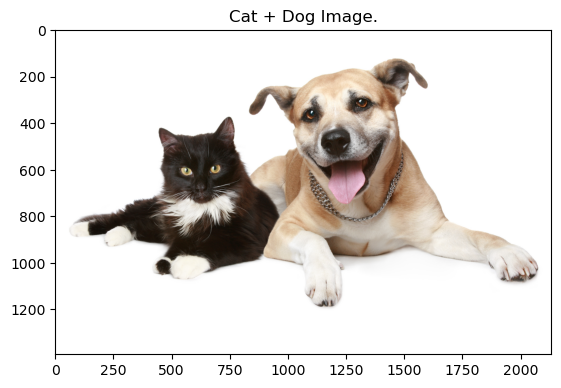

In [74]:
# Both
pil_image_both = Image.open(requests.get("https://th.bing.com/th/id/R.3a2b0947afe4f3545d07cc781f8e4631?rik=05MeI%2fvZq2ryxg&riu=http%3a%2f%2fyesofcorsa.com%2fwp-content%2fuploads%2f2017%2f04%2fCat-And-Dog-Wallpaper-Download.jpg&ehk=9aBB%2bHNJRqn1DHVDoNWMZrBEV6cAckI0gGqf1Ae03Uk%3d&risl=1&pid=ImgRaw&r=0", 
                                  stream=True).raw)
pil_image_both = pil_image_both.resize(size=(pil_image_both.width // 2, pil_image_both.height // 2))
plt.imshow(pil_image_both)
plt.title("Cat + Dog Image.")
plt.show()

## GradCAM for the predicted label

Finally, GradCAM is applied to justify the model prediction.

- $G_{p=1}$ matches the GradCAM output for the specified class (= `target` parameter in the `justify` function). It highlights the regions of the image that maximize the probability of the `target`.
- $G_{p=0}$ is $G_{p=1}$ inverted. It highlights the regions of the image that minimize the probability of the `target`.

Note: In this example $G_{p=0}$ is not too usefull. However, for a binary classifier that only putputs the logit of the positive class (like the models trained in this project, objects of the `SingleLogitResnet` class), $G_{p=1}$ matches the GradCAM of the positive class and $G_{p=0}$ matches the GradCAM of the negative class. There's no need to run the algorithm for both classes. 

- The predicted class is "American Staffordshire terrier" with a 5.93% probability.


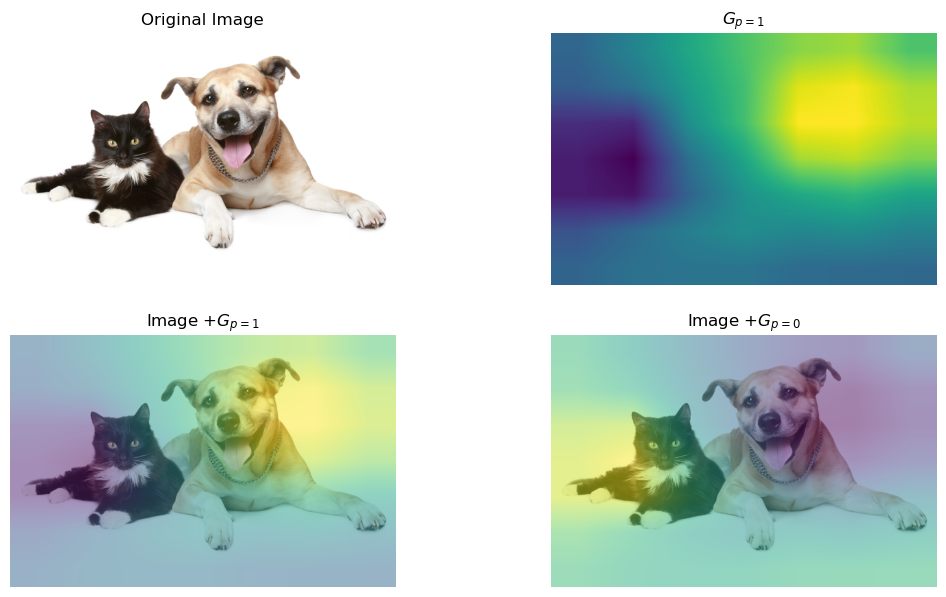

In [84]:
import importlib, utilities
importlib.reload(utilities.eval)

# Predciting
model.eval()
with torch.no_grad():
    # Keep in mind that when predicting an image, the preprocessing transformations need to be performed.
    batch = preprocessing_transforms(pil_image_both).unsqueeze(0).to('cuda') 
    prediction = model(batch).squeeze(0).softmax(0)
    p_label = prediction.argmax().item()
    score = prediction[p_label].item()
    category_name = weights.meta["categories"][p_label]
    print("- The predicted class is \"{}\" with a {:.2f}% probability.".format(category_name, 100 * score))
# GradCAM
p_filter, n_filter = utilities.eval.justify(
    model=model,
    t = preprocessing_transforms,
    layer = model.layer4[1].conv2,
    pil_image = pil_image_both,
    target = p_label
)

The predicted class, `American Staffordshire`, is a dog class. The left side of the image (where the cat is located) minimizes the probability of the image belonging to this class, while the right part of the photo (where the dog is located) pushes the model to predict a dog class.

> Note: Remember that ImageNet has 1000 classes, including several for different species of dogs and cats (to grant intra classification accuracy), that's why the predicted label probability may seem low. However, an "American Staffordshire" is a dog.

### Extra

As an extra feature, justify returns the unresized feauture maps generated by GradCAM.

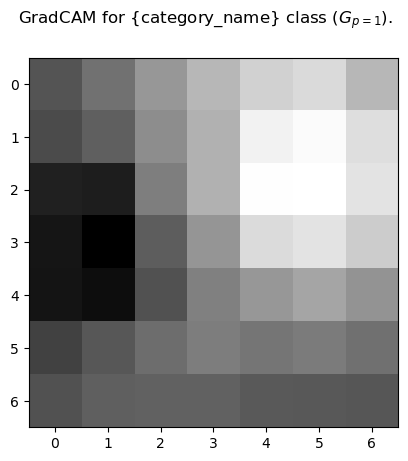

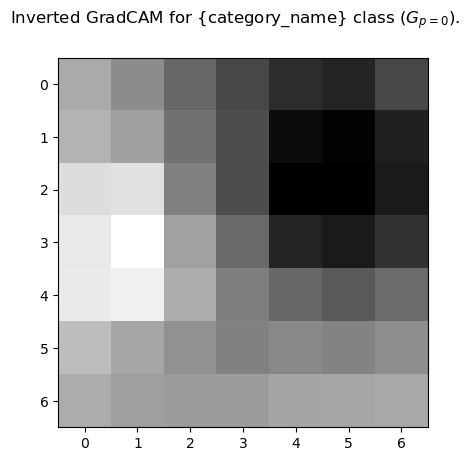

In [81]:
plt.imshow(
                X = v2.functional.to_pil_image(p_filter),
                cmap='gray',
            )
plt.suptitle(r"GradCAM for {category_name} class ($G_{p=1}$).")
plt.show()
# p == 0
plt.imshow(
        X = v2.functional.to_pil_image(n_filter),
        cmap='gray',
    )
plt.suptitle(r"Inverted GradCAM for {category_name} class ($G_{p=0}$).")
plt.show()

## GradCam for other labels

GradCAM can be applied to the score of other classes. Applying GradCAM to a cat class (`tabby`), the left side of the image (where the cat is located) maximizes the probability of the image belonging to this class, while the right part of the image (where the dog is located) minimizes it.

- The class "tabby" is predicted with a 0.65% probability.


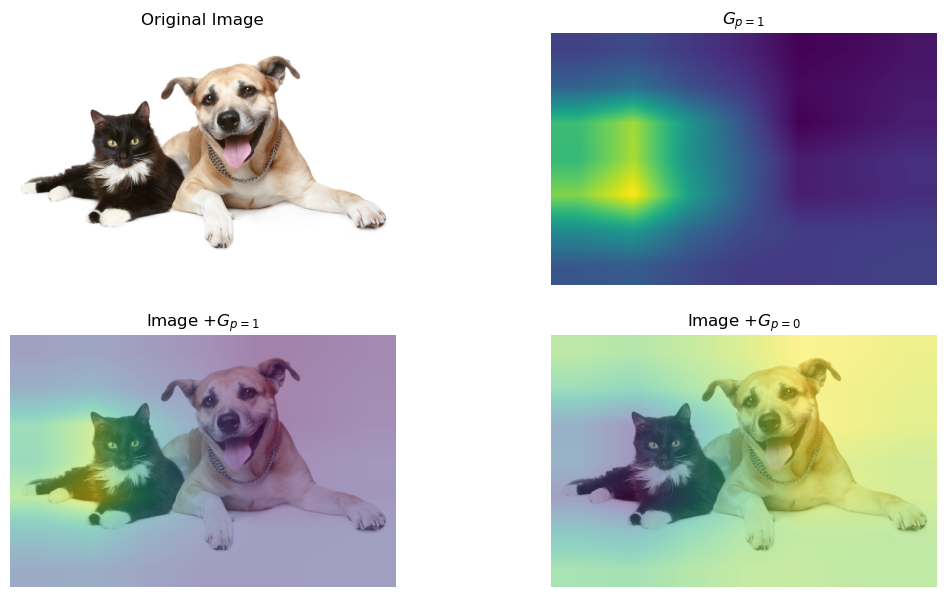

In [85]:
tabby_label = weights.meta["categories"].index("tabby")
model.eval()
with torch.no_grad():
    batch = preprocessing_transforms(pil_image_both).unsqueeze(0).to('cuda')
    prediction = model(batch).squeeze(0).softmax(0)
    score = prediction[tabby_label].item()
    category_name = weights.meta["categories"][tabby_label]
    print("- The class \"{}\" is predicted with a {:.2f}% probability.".format(category_name, 100 * score))

_, _ = utilities.eval.justify(
    model=model,
    t = preprocessing_transforms,
    layer = model.layer4[1].conv2,
    pil_image = pil_image_both,
    target = tabby_label
)